# Convolutional Neural Networks
## Image classification with CNNs
### Author: Malik Rawashdeh
### Date: 04/08/2024

### Data Loading and Exploration

Below we will load the MNIST dataset using a custom dataloader and visualize some of the images in the dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# import the necessary pytorch packages
from PIL import Image
import torch

In [4]:

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
"""
This function will load the data from the nparray objects and create a DataLoader object for the training data

Parameters:
    batch_size: the size of the batch that will be used for training
    validation_size: the size of the validation set
    x_train: the training data
    y_train: the training labels
    x_test: the testing data
"""
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def custome_dataloader(batch_size, validation_size, x_train, y_train, x_test):
    data_transform = transforms.Compose([
        # Flip the images randomly on the horizontal
        # Turn the image into a torch.Tensor
        transforms.Grayscale(num_output_channels=1), # convert the image to grayscale
        transforms.RandomHorizontalFlip(), # randomly flip the image horizontally
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])
    # convert image numpy arrays to float32
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)

    # tranform the data
    # x_train = data_transform(x_train)
    # y_train = data_transform(y_train)
    # x_test = data_transform(x_test)

    # convert the numpy arrays to PyTorch tensors and transform them
    x_train = torch.tensor(x_train).to(device)
    y_train = torch.tensor(y_train).to(device)
    x_test = torch.tensor(x_test).to(device)

    print("x_train shape: ", x_train.shape)
    print("y_train shape: ", y_train.shape)
    print("x_test shape: ", x_test.shape)





    # create a DataLoader object for the training data
    train_data_tensor = torch.utils.data.TensorDataset(x_train, y_train)
    test_data_set = torch.utils.data.TensorDataset(x_test)

    # split the training data into a training and validation set
    num_validation = int(validation_size * len(train_data_tensor))

    train_data_set, val_data_set = torch.utils.data.random_split(train_data_tensor, [len(train_data_tensor) - num_validation, num_validation])

    train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(dataset=val_data_set, batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(dataset=test_data_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader




cuda


In [6]:
# load the training data from .npy files
y_train = np.load('./drive/MyDrive/y_train.npy')
x_test = np.load('./drive/MyDrive/x_test.npy')
x_train = np.load('./drive/MyDrive/x_train.npy')

# check the shape of the data
print(f"The shape of the training data is: {x_train.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the test data is: {x_test.shape}")


The shape of the training data is: (60000, 784)
The shape of the training labels is: (60000,)
The shape of the test data is: (10000, 28, 28)


In [7]:
# print the data types of the data
print(f"The data type of the training data is: {x_train.dtype}")
print(f"The data type of the training labels is: {y_train.dtype}")
print(f"The data type of the test data is: {x_test.dtype}")

The data type of the training data is: float64
The data type of the training labels is: int64
The data type of the test data is: float64


### Data Shape
From the shapes of the training and testing data, we can see that the training data has 60,000 images of size 28x28 pixels, while the testing data has 10,000 images of the same size.
- The x_train array must be resized to 28x28 for each element in the array to be displayed as an image.
- The x_test array is already in the correct shape.

In [8]:
# reshape the x data
x_train = x_train.reshape(-1, 28, 28)

### Image Visualization and Digit distribution

Below we will visualize the first example of each digit (0-9) in the training data and plot the distribution of the digits in the training data.

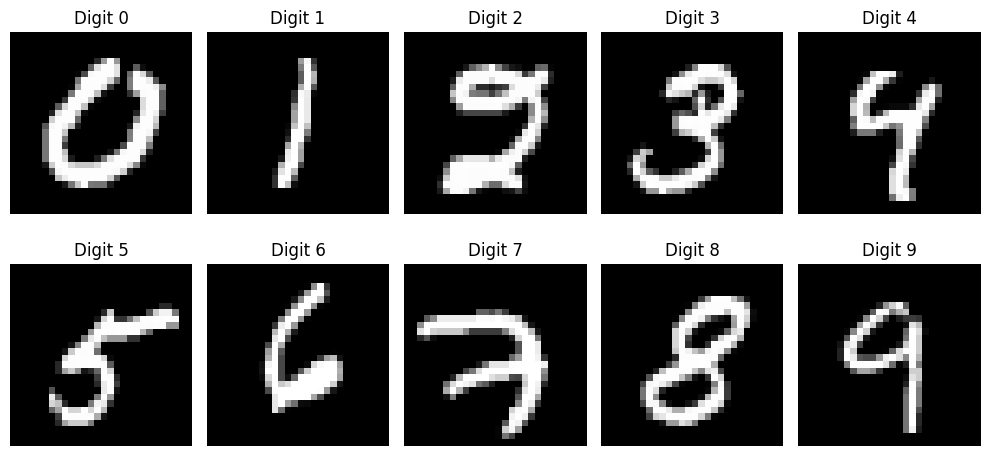

In [9]:
# Visualize one example from each digit category
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    digit_index = np.where(y_train == i)[0][0]  # Find the index of the first occurrence of digit i
    plt.imshow(x_train[digit_index], cmap='gray')
    plt.title(f'Digit {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

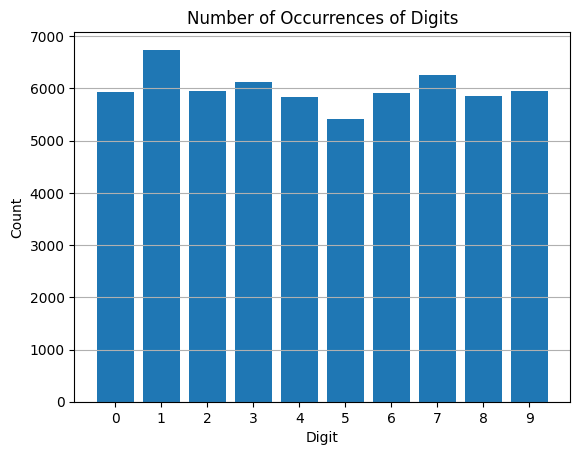

In [10]:
# show the distribution of the labels
# Assuming y_train is your target labels
unique_digits, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_digits, counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Occurrences of Digits')
plt.xticks(unique_digits)
plt.grid(axis='y')
plt.show()

In [11]:
digit_cnt = np.bincount(y_train)
for i in range(10):
    print(f"Digit {i} count: {digit_cnt[i]}")

# min, max and mean of the digit count
print(f"Min digit count: {np.min(digit_cnt)}")
print(f"Max digit count: {np.max(digit_cnt)}")
print(f"Mean digit count: {np.mean(digit_cnt)}")

Digit 0 count: 5923
Digit 1 count: 6742
Digit 2 count: 5958
Digit 3 count: 6131
Digit 4 count: 5842
Digit 5 count: 5421
Digit 6 count: 5918
Digit 7 count: 6265
Digit 8 count: 5851
Digit 9 count: 5949
Min digit count: 5421
Max digit count: 6742
Mean digit count: 6000.0


### Digit Count Distribution
From examining the y labels in the training data, we can see that the distribution of the digits is relatively uniform, with each digit appearing approximately 6000 times in the training data. This is important as it ensures that the model will be trained on a balanced dataset.

While the count of each digit is not exactly 6000, the distribution is close enough to be considered uniform as it averages out to 6000.

### Creating Loaders and Preprocessing
In order to train the model, we need to create data loaders for the training and testing data. We will also normalize the data by dividing by 255 to scale the pixel values to the range [0,1].

Since the images are grayscale, we will add a channel dimension to the images to make them compatible with the convolutional layers in the model.

In [12]:
# find the max pixel value in the training data to see if the data is normalized
max_pixel_value = np.max(x_train)
print(f"The max pixel value in the training data is: {max_pixel_value}")

The max pixel value in the training data is: 1.0


Since the max value of the pixels is 1, we do not need to divide by 255.

In [13]:
# add a channel dimension to the data to make it compatible with PyTorch
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
# check the shape of the data
print(f"The shape of the training data is: {x_train.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the test data is: {x_test.shape}")

The shape of the training data is: (60000, 1, 28, 28)
The shape of the training labels is: (60000,)
The shape of the test data is: (10000, 1, 28, 28)


In [14]:
train_loader, validation_loader, test_loader = custome_dataloader(64, 0.2, x_train, y_train, x_test)

x_train shape:  torch.Size([60000, 1, 28, 28])
y_train shape:  torch.Size([60000])
x_test shape:  torch.Size([10000, 1, 28, 28])


In [15]:
# print the number of batches in the training and validation data
print(f"The number of batches in the training data is: {len(train_loader)}")
print(f"The number of batches in the validation data is: {len(validation_loader)}")
print(f"The number of batches in the test data is: {len(test_loader)}")

X, y = next(iter(train_loader))
print("Training Loader example shape")
print(f"X shape: {X.shape}; y shape: {y.shape}")

The number of batches in the training data is: 750
The number of batches in the validation data is: 188
The number of batches in the test data is: 157
Training Loader example shape
X shape: torch.Size([64, 1, 28, 28]); y shape: torch.Size([64])


Now we will check the shape of the test loader iterables which will help later. As can be seen below we will have to unpack the torch tensors when we do predictions.

In [16]:
X = next(iter(train_loader))
print(f"len(X): {len(X)}")
print(f"shape of X: {X[0].shape}")

len(X): 2
shape of X: torch.Size([64, 1, 28, 28])


In [17]:
import torch.nn as nn

### CNN Model Archetecture and Training
The CNN model consists of convolutional layers followed by max pooling layers, inputted activation functions, and fully connected layers. The model is trained using the Adam optimizer and cross-entropy loss function.

The CNN model below is adapted from the week 11 discussions on Canvas. I augmented the model from canvas by adding params for the kernel size (ie filter size), the number of layers, and the drop out rate. I also added a validation loop to tune the hyperparameters.

### Model Architecture
The model will take in a 1 channel image of size 28x28 and pass it through at least 2 convolutional layers. In similar fashion to the Discussions posted on canvas, I establish `cnn_block` and `linear_block` classes. The output of the last cnn block is passed through a fully connected layer and then to a classification layer.

The model allows tunable hyper parameters for:
- the number of convolutional layers,
- the filter/kernel size,
- stride size,
- and the dropout rate.
### NOTE: Here when I refer to the number of convolutional `layers`, I am referring to the number of cnn blocks in the model. Each cnn block consists of 2 convolutional layers, 2 batch normalizations, and 2 activation function as is explained below
Hence the number of convolutional layers is the num_cnn_layers * 2.
The number of fully connected layers is the number of linear blocks * 2 in the model since each linear block consists of 2 fully connected layers and 2 activation functions.
#### CNN Block
The CNN block consists of the following layers:
- Convolutional Layer: Applies a 2D convolution over an input signal composed of a 1 channel image of size 28x28. The convolutional layer is followed by a batch normalization layer.
- Activation Function: Applies the inputted activation function (default ReLU) to the output of the convolutional layer.
In order to ensure the same output size as the input, the padding is calculated as follows:
- padding = (kernel_size - 1) / 2
This ensures that the output size is the same as the input size.
I also added a dropout layer after the fully connected layer to prevent overfitting.
In the forward pass (ie the output of the block), I use the skip connection to add the input to the output of the convolutional layer.

#### Linear Block
The linear block consists of the following layers:
- 2 Linear Layers: Applies a linear transformation to the incoming data.
- Activation Function: Applies the inputted activation function (default ReLU) to the output of the linear layer.
- Dropout Layer: Applies dropout to the output of the linear layer to prevent overfitting.



In [18]:

class cnn_block(nn.Module):
    def __init__(self, in_channels=1, n_hidden=5, kernel_size=(2, 2), stride=1, activation_func=nn.ReLU(), dropout=0.2):
        super().__init__()
        # Calculate padding to maintain input size
        # The value of padding = (k-1)/2 since (n+2padding-k+1) = n
        # for [(n + 2padding) x (n + 2ppadding) input] * [(k x k) kernel] —> [(n x n) same input size].
        padding = ((kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=n_hidden, kernel_size=kernel_size, bias=False, padding=padding),
            nn.BatchNorm2d(num_features=n_hidden),
            activation_func,
            nn.Dropout(p=dropout),
            nn.Conv2d(in_channels=n_hidden, out_channels=in_channels, kernel_size=kernel_size, bias=False, padding=padding),
            nn.BatchNorm2d(num_features=in_channels),
            activation_func,
            nn.Dropout(p=dropout))

    def forward(self, x):
        # residual + conv layers for skip connection
        return x + self.layers(x)

class linear_block(nn.Module):
    def __init__(self, in_features, n_hidden, activation_func=nn.ReLU(), dropout=0.2):
        super().__init__()
        self.in_features = (in_features, n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_hidden),
            activation_func,
            nn.Dropout(p=dropout),
            nn.Linear(in_features=n_hidden, out_features=in_features),
            activation_func,
        )

    def forward(self, x):
        return x + self.layers(x)

class CNNClassifier(nn.Module):
    def __init__(
                 self,
                 in_channels=1,
                 cnn_channels=5,
                 linear_hidden=128,
                 n_classes=10,
                 kernel_size=(3, 3),
                 stride=1,
                 cnn_layers=3,
                 activation_func=nn.ReLU(),
                 dropout_rate=0.2
                ):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            *[cnn_block(in_channels, cnn_channels, kernel_size, stride=stride, activation_func=activation_func, dropout=dropout_rate) for _ in range(cnn_layers)])

        self.down_sample = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(1, 1))

        self.linear_layers = nn.Sequential(
            linear_block(28 * 28, linear_hidden, activation_func=activation_func, dropout=dropout_rate),  # Adjusted input size for single-channel grayscale image
            linear_block(28 * 28, linear_hidden, activation_func=activation_func, dropout=dropout_rate)  # Adjusted input size for single-channel grayscale image
        )
        # Output layer
        self.last_layer = nn.Linear(28 * 28, n_classes)  # Adjusted input size for single-channel grayscale image

        self.all = nn.Sequential(
            self.cnn_layers,
            self.down_sample,
            nn.Flatten(),
            self.linear_layers,
            self.last_layer,
        )

    def forward(self, x):
        return self.all(x)


### Training the Model
The model is trained using the Adam optimizer and cross-entropy loss function. The model is trained for a specified number of epochs and the training and validation loss and accuracy are recorded for each epoch. The model with the best validation accuracy is selected as the final model.

Below is a function I created which will train the model and return the training and validation loss and accuracy for each epoch. The function takes in the model, training and validation data loaders, the number of epochs, and the learning rate as input parameters.

In [19]:
# Function to train the model
from torch.optim import Adam
from tqdm import tqdm
loss_func = nn.CrossEntropyLoss().to(device)
print("Training with device", device)
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    avg_accuracy = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_train_loss = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # check the dimensions of the images
            preds = model(images)

            loss = loss_func(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        epoch_val_loss = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = loss_func(preds, labels)
                epoch_val_loss.append(loss.item())
                _, predicted = torch.max(preds.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        avg_accuracy += accuracy

    return avg_accuracy / num_epochs


Training with device cuda


### Hyperparameter Tuning and Model Selection
I will use the validation data to select the best hyperparameters for the model. I will test the following hyperparameters:
- Number of Convolutional Layers: 2, 3
- Activation Function: ReLU, Sigmoid
- Filter Size: 3, 5
- Dropout Rate: 0.2, 0.5
- Stride: 1

In [20]:

# Define hyperparameters to search
num_layers_list = [2, 3]
activation_list = [nn.ReLU(), nn.Sigmoid()]
dropout_list = [0.2, 0.5]
kernel_sizes = [(3, 3), (5, 5)]
strides = [1]
models = {
}
sorted_models = []

# Perform hyperparameter search
best_accuracy = 0
best_hyperparameters = None


for num_layers in num_layers_list:
    for activation in activation_list:
        for dropout in dropout_list:
            for filter_size in kernel_sizes:
                for stride in strides:
                    model = CNNClassifier(
                        in_channels=1,
                        cnn_channels=5,
                        linear_hidden=128,
                        n_classes=10,
                        kernel_size=filter_size,
                        stride=stride,
                        cnn_layers=num_layers,
                        activation_func=activation,
                        dropout_rate=dropout
                        ).to(device)
                    print(f"Training model with hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})")
                    cur_accuracy = train_model(model, train_loader, validation_loader)
                    if cur_accuracy > best_accuracy:
                        best_accuracy = cur_accuracy
                        best_hyperparameters = {'num_layers': num_layers, 'activation': activation, 'dropout': dropout, 'kernel_size': filter_size, 'stride': stride}
                    print(f'Accuracy: {cur_accuracy:.4f}, Hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})')
                    print()
                    models[(num_layers, activation, dropout, filter_size)] = model
                    sorted_models.append((cur_accuracy, (num_layers, activation, dropout, filter_size, stride)))


print('Best hyperparameters:', best_hyperparameters)
print('Best validation accuracy:', best_accuracy)

Training model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


Accuracy: 0.9658, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


Accuracy: 0.9727, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Accuracy: 0.9647, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:40<00:00,  4.00s/it]


Accuracy: 0.9663, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


Accuracy: 0.9643, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:38<00:00,  3.90s/it]


Accuracy: 0.9630, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Accuracy: 0.9440, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Accuracy: 0.9560, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Accuracy: 0.9698, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Accuracy: 0.9782, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Accuracy: 0.9555, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Accuracy: 0.9524, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Accuracy: 0.9672, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Accuracy: 0.9590, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Accuracy: 0.9408, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.69s/it]

Accuracy: 0.9571, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Best hyperparameters: {'num_layers': 3, 'activation': ReLU(), 'dropout': 0.2, 'kernel_size': (5, 5), 'stride': 1}
Best validation accuracy: 0.9782249999999999


In [21]:
sorted_models.sort(reverse=True)
print("Best models ranked")
for i, (accuracy, hyperparameters) in enumerate(sorted_models):
    print(f'{i}. Accuracy: {accuracy:.4f}, Num layers: {hyperparameters[0]}, Activation: {hyperparameters[1]}, Dropout: {hyperparameters[2]}, Kernel size: {hyperparameters[3]}, Stride: {hyperparameters[4]}')

Best models ranked
0. Accuracy: 0.9782, Num layers: 3, Activation: ReLU(), Dropout: 0.2, Kernel size: (5, 5), Stride: 1
1. Accuracy: 0.9727, Num layers: 2, Activation: ReLU(), Dropout: 0.2, Kernel size: (5, 5), Stride: 1
2. Accuracy: 0.9698, Num layers: 3, Activation: ReLU(), Dropout: 0.2, Kernel size: (3, 3), Stride: 1
3. Accuracy: 0.9672, Num layers: 3, Activation: Sigmoid(), Dropout: 0.2, Kernel size: (3, 3), Stride: 1
4. Accuracy: 0.9663, Num layers: 2, Activation: ReLU(), Dropout: 0.5, Kernel size: (5, 5), Stride: 1
5. Accuracy: 0.9658, Num layers: 2, Activation: ReLU(), Dropout: 0.2, Kernel size: (3, 3), Stride: 1
6. Accuracy: 0.9647, Num layers: 2, Activation: ReLU(), Dropout: 0.5, Kernel size: (3, 3), Stride: 1
7. Accuracy: 0.9643, Num layers: 2, Activation: Sigmoid(), Dropout: 0.2, Kernel size: (3, 3), Stride: 1
8. Accuracy: 0.9630, Num layers: 2, Activation: Sigmoid(), Dropout: 0.2, Kernel size: (5, 5), Stride: 1
9. Accuracy: 0.9590, Num layers: 3, Activation: Sigmoid(), Drop

### Predict the test data based on the best model
I use the best model found in the validation loop to predict the test data. I then save the predictions to a csv file for submission. To predict the image labels, I use the max value of the output of the model as the predicted label.

I then convert the tensor to a numpy array and save it to a csv file.

In [22]:
# use the best model to predict the test data
best_model = models[(best_hyperparameters['num_layers'], best_hyperparameters['activation'], best_hyperparameters['dropout'], best_hyperparameters['kernel_size'])]

best_model.eval()
# create
preds = []

with torch.no_grad():
    for images in test_loader:
        images = images[0].to(device)
        output = best_model(images)
        _, predicted = torch.max(output.data, 1)
        preds.extend(predicted.cpu().numpy())

# save the predictions to a csv file names Malik_Rawashdeh_Preds.csv
preds = np.array(preds)
pred_df = pd.DataFrame(preds, columns=['Predicted Label'])
pred_df.to_csv('Malik_Rawashdeh_Preds.csv', index=False)
print("Predicted digit labels saved to 'Malik_Rawashdeh_Preds.csv'")


Predicted digit labels saved to 'Malik_Rawashdeh_Preds.csv'
